# K-means and Bisecting K-means in PySpark's MLlib

Welcome to the first clustering code along activity!

**Recall from the Intro to Clustering lecture** <br>
Clustering is a technique for unsupervised learning which I like to think of as “Smart Grouping”. The "unsupervised" part of this type approach just means that you do not have a dependent variable to work with which means you need to get a bit more creative. That's where clustering comes in handy. 

### K-means
The k-means algorithms divides the data points of a dataset into clusters (groups) based on the nearest average (mean) values. In order to find the mean data point the algorithm tries to minimize the distance between points in each cluster. 

In the term "k-means", k denotes the number of clusters in the data. Since the k-means algorithm doesn’t determine this, you’re required to specify this quantity. The quality of the clusters is heavily dependent on on how good you were at guessing the value of k. If your data just has 2 or three variables to work with, that might be easy to guess by looking at a scatter plot, but when your data has several variables that approach will be nearly impossible. So we basically guess and check until we figure out the best guess.

The k-means algorithm works by placing random cluster centers around your ploting area and then evaluating whether moving them in any one direction would result in a new center with better results (higher density) — with more data points closer to it.

**PySpark documentation:** <br> https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.KMeans

### Bi-secting K-means

Very similar to k-Means clustering. It starts with all objects in a single cluster, and then..

    1. Picks a cluster to split.
    2. Find 2 sub-clusters using the basic k-Means algorithm (Bisecting step)
    3. Repeat step 2, the bisecting step, until there are k leaf clusters in total or no leaf clusters are divisible. The bisecting steps of clusters on the same level are grouped together to increase parallelism that Spark provides. If bisecting all divisible clusters on the bottom level would result more than k leaf clusters, larger clusters get higher priority.
    4. Repeat steps 1, 2 and 3 until the desired number of clusters is reached.


**PySpark documentation:** <br> https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.BisectingKMeans

So let's see them both in action!

In [63]:
# First let's create our PySpark instance
# import findspark
# findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("kmeans").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


## Import dataset

**Content**

This dataset summarizes the usage behavior of about 9,000 credit card holders during the last 6 months that we will use to define a marketing outreach strategy for. Basically we want to see how we can get our customers to purchase more! The file is at a customer level with 18 behavioral variables.

**Data Dictionary:**

 - **CUST_ID:** Identification of Credit Card holder (Categorical) 
 - **BALANCE:** Balance amount left in their account to make purchases 
 - **BALANCE_FREQUENCY:** How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated) 
 - **PURCHASES:** Amount of purchases made from account 
 - **ONEOFF_PURCHASES:** Maximum purchase amount done in one-go 
 - **INSTALLMENTS_PURCHASES:** Amount of purchase done in installment 
 - **CASH_ADVANCE:** Cash in advance given by the user 
 - **PURCHASES_FREQUENCY:** How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased) 
 - **ONEOFFPURCHASESFREQUENCY:** How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased) 
 - **PURCHASESINSTALLMENTSFREQUENCY:** How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done) 
 - **CASHADVANCEFREQUENCY:** How frequently the cash in advance being paid 
 - **CASHADVANCETRX:** Number of Transactions made with "Cash in Advanced" 
 - **PURCHASES_TRX:** Number of purchase transactions made 
 - **CREDIT_LIMIT:** Limit of Credit Card for user 
 - **PAYMENTS:** Amount of Payment done by user 
 - **MINIMUM_PAYMENTS:** Minimum amount of payments made by user 
 - **PRCFULLPAYMENT:** Percent of full payment paid by user TENURE : Tenure of credit card service for user

**Source:** https://www.kaggle.com/arjunbhasin2013/ccdata

In [11]:
path ="Datasets/"
df = spark.read.csv(path+'credit_card_data.csv',inferSchema=True,header=True)

In [12]:
df.limit(5).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [13]:
df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



## Check the nulls values

In [16]:
df.limit(5).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [20]:
from pyspark.sql.functions import *

def null_value_cal(df):
    null_columns_count = []
    numRows = df.count()
    for col in df.columns:
        num_null = df.where(df[col].isNull()).count()
        '''
        if num_null > 0:
            avg = df.agg(mean(col)).collect()[0][0]
            df.fillna(avg, subset = [col])
            assert df.where(df[col].isNull()).count() == 0
        '''
        if num_null > 0:
            temp = col, num_null, num_null/numRows * 100
            null_columns_count.append(temp)
            
            avg = df.agg(mean(col)).collect()[0][0]
            df = df.na.fill({col: avg})
            #print(avg, df.where(df[col].isNull()).count())
            assert df.where(df[col].isNull()).count() == 0
            
    return null_columns_count, df

null_columns_count, df = null_value_cal(df)
null_df = spark.createDataFrame(null_columns_count, ['column', 'num_null', 'pct_null'])
null_df.show()

4494.449450364621 0
864.2065423050816 0
+----------------+--------+------------------+
|          column|num_null|          pct_null|
+----------------+--------+------------------+
|    CREDIT_LIMIT|       1|0.0111731843575419|
|MINIMUM_PAYMENTS|     313|3.4972067039106145|
+----------------+--------+------------------+



In [5]:
from pyspark.sql.functions import *

def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(df)
spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()

+----------------+-----------------+------------------+
|     Column_Name|Null_Values_Count|Null_Value_Percent|
+----------------+-----------------+------------------+
|    CREDIT_LIMIT|                1|0.0111731843575419|
|MINIMUM_PAYMENTS|              313|3.4972067039106145|
+----------------+-----------------+------------------+



### Fill in null values

Fill in null values with average (except for the ID column)

In [6]:
from pyspark.sql.functions import *
def fill_with_mean(df, include=set()): 
    stats = df.agg(*(avg(c).alias(c) for c in df.columns if c in include))
    return df.na.fill(stats.first().asDict())

columns = df.columns
columns = columns[1:]
df = fill_with_mean(df, columns)
df.limit(5).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


**Convert all input columns (features) into a vector**

*Remember that we don't have a dependent variable here.*

In [21]:
from pyspark.ml.feature import VectorAssembler
input_columns = df.columns[1:]
vectorizer = VectorAssembler(inputCols = input_columns, outputCol = 'features')
vectorized_data = vectorizer.transform(df).select('features')
vectorized_data.show()

+--------------------+
|            features|
+--------------------+
|[40.900749,0.8181...|
|(17,[0,1,5,9,10,1...|
|[2495.148862,1.0,...|
|[1666.670542,0.63...|
|[817.714335,1.0,1...|
|[1809.828751,1.0,...|
|[627.260806,1.0,7...|
|[1823.652743,1.0,...|
|[1014.926473,1.0,...|
|[152.225975,0.545...|
|[1293.124939,1.0,...|
|[630.794744,0.818...|
|[1516.92862,1.0,3...|
|[921.693369,1.0,2...|
|(17,[0,1,5,9,10,1...|
|[6886.213231,1.0,...|
|(17,[0,1,5,9,10,1...|
|[41.089489,0.4545...|
|[1989.072228,1.0,...|
|[3577.970933,1.0,...|
+--------------------+
only showing top 20 rows



In [22]:
from pyspark.ml.feature import VectorAssembler
input_columns = df.columns # Collect the column names as a list
input_columns = input_columns[1:] # keep only relevant columns: from column 8 until the end
vecAssembler = VectorAssembler(inputCols=input_columns, outputCol="features")
df_kmeans = vecAssembler.transform(df) #.select('CUST_ID', 'features')
df_kmeans.limit(4).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,features
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,"[40.900749, 0.818182, 95.4, 0.0, 95.4, 0.0, 0...."
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,"(3202.467416, 0.909091, 0.0, 0.0, 0.0, 6442.94..."
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,"[2495.148862, 1.0, 773.17, 773.17, 0.0, 0.0, 1..."
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,"[1666.670542, 0.636364, 1499.0, 1499.0, 0.0, 2..."


## K-means

One disadvantage of KMeans compared to more advanced clustering algorithms is that the algorithm must be told how many clusters, k, it should try to find. To optimize k (find the right amount of clusters) we cluster a fraction of the data for different choices of k and look for an "elbow" in the cost function.

**Source:** https://rsandstroem.github.io/sparkkmeans.html

In [23]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

In [42]:
kmax = 30

kmcost = np.zeros(kmax + 1)

for k in range(2, kmax + 1):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(df_kmeans)
    
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    kmcost[k] = evaluator.evaluate(predictions)

Text(0, 0.5, 'cost')

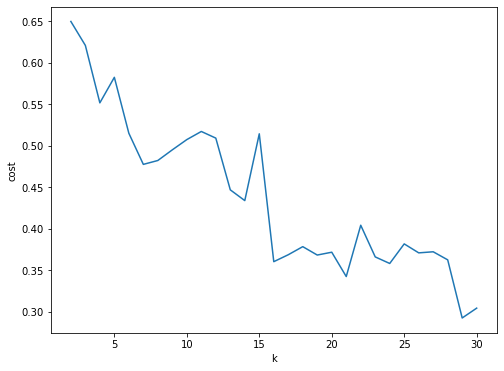

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(2, kmax+1), kmcost[2:])
plt.xlabel("k")
plt.ylabel('cost')

In [51]:
# Find the best amount of clusters
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

# set a max for the number of clusters you want to try out
kmax = 50
# Create and array filled with zeros for the amount of k
# Similar to creating an empty list
kmcost = np.zeros(kmax)
for k in range(2,kmax):
    # Set up the k-means alogrithm
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    # Fit it on your dataframe
    model = kmeans.fit(df_kmeans)
    # Fill in the zeros of your array with cost....
    # Computes the "cost" (sum of squared distances) between the input points and their corresponding cluster centers.
    # For Spark 2.0 to 3.0
    kmcost[k] = model.distanceMeasure()
    
    # For Spark 3.0+
#     predictions = model.transform(df_kmeans)
#     evaluator = ClusteringEvaluator()
#     kmcost[k] = evaluator.evaluate(predictions) #computing Silhouette score

AttributeError: 'KMeansModel' object has no attribute 'computeCost'

Can you see the "elbow" below?

Text(0, 0.5, 'cost')

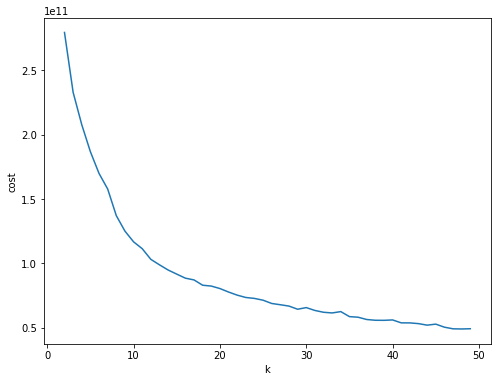

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up the plot dimensions
fig, ax = plt.subplots(1,1, figsize =(8,6))
# Then specify the range of values for the axis and call on your cost array
ax.plot(range(2,kmax),kmcost[2:kmax])
# Set up the axis labels
ax.set_xlabel('k')
ax.set_ylabel('cost')

Looks like the "elbow" is at about 15 or so....

Less clusters is always better. 

## Bisecting k-means

Now let's compare with bi-secting k-means.

Text(0, 0.5, 'cost')

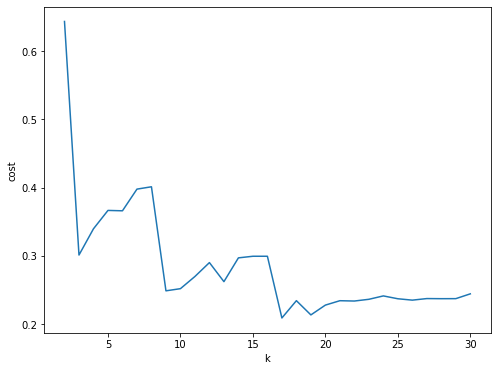

In [44]:
from pyspark.ml.clustering import BisectingKMeans

kmax = 30
bkmcost = np.empty(kmax + 1)

for k in range(2, kmax + 1):
    bisect_kmeans = BisectingKMeans().setK(k).setSeed(1)
    model = bisect_kmeans.fit(df_kmeans)
    
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    bkmcost[k] = evaluator.evaluate(predictions)

fig, ax = plt.subplots(1, 1, figsize = (8, 6 ))
ax.plot(range(2, kmax + 1), bkmcost[2:])
ax.set_xlabel("k")
ax.set_ylabel("cost")

In [42]:
from pyspark.ml.clustering import BisectingKMeans

# Same calls here except with bkmeans
kmax = 50
bkmcost = np.zeros(kmax)
for k in range(2,kmax):
    bkmeans = BisectingKMeans().setK(k).setSeed(1)
    model = bkmeans.fit(df_kmeans)
    
    # For Spark > 2.0 AND Spark < 3.0
    bkmcost[k] = model.computeCost(df_kmeans)
    
    # For Spark 3.0+
#     predictions = model.transform(df_kmeans)
#     evaluator = ClusteringEvaluator()
#     bkmcost[k] = evaluator.evaluate(predictions) #computes Silhouette score

Text(0, 0.5, 'cost')

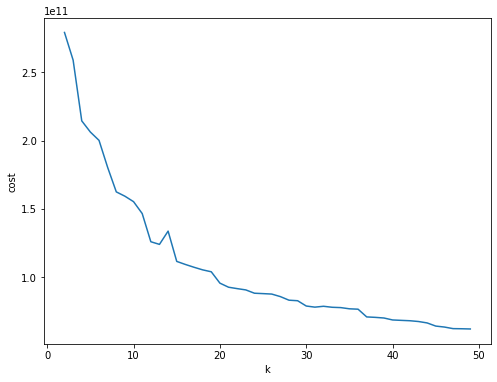

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('cost')

Looks like this line is telling a similar story but it's a bit less smooth which is concerning. This is a red flag that the model could be unreliable. 

#### Compare the two models 

1. Plot them together
2. We can also compare the two models above by calculating the difference between cost values at various k values (kmeans - bisecting kmeans). So negative values means k-means is winning and positive values means bi-secting k-means is winning. 

Let's see who wins!

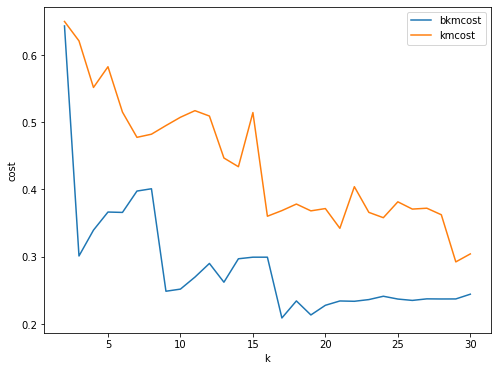

In [48]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(range(2, kmax + 1), bkmcost[2:], label= 'bkmcost')
ax.plot(range(2, kmax + 1), kmcost[2:], label='kmcost')
ax.set_xlabel("k")
ax.set_ylabel("cost")
plt.legend()
plt.show()

In [50]:
k = 17

bisect_kmeans = BisectingKMeans().setK(k).setSeed(1)
model = bisect_kmeans.fit(df_kmeans)

predictions = model.transform(df_kmeans)
evaluator = ClusteringEvaluator()
cost = evaluator.evaluate(predictions)
print(cost)

centers = model.clusterCenters()
print([center for center in centers])

0.20892427379308898
[array([2.16633658e+02, 7.11999905e-01, 3.75507349e+02, 1.33926239e+02,
       2.41632295e+02, 1.10869329e+02, 4.96137539e-01, 8.64123384e-02,
       4.11876432e-01, 3.07019397e-02, 5.50646552e-01, 8.48599138e+00,
       3.02114224e+03, 4.39370348e+02, 2.43191424e+02, 2.32069529e-01,
       1.16185345e+01]), array([5.66640443e+02, 8.48334756e-01, 3.27150129e+02, 1.37393094e+02,
       1.90108401e+02, 2.12593580e+02, 4.38516981e-01, 9.61557753e-02,
       3.45354501e-01, 8.66123086e-02, 1.49294020e+00, 7.36129568e+00,
       1.31513843e+03, 5.03675514e+02, 3.60101368e+02, 1.36686112e-01,
       1.11237542e+01]), array([1.36514323e+03, 9.28667296e-01, 7.27509889e+02, 4.08434930e+02,
       3.19220155e+02, 1.00386047e+03, 4.09703737e-01, 1.79395297e-01,
       2.87193473e-01, 1.93451726e-01, 4.44132841e+00, 1.11911439e+01,
       2.34067856e+03, 1.55328005e+03, 6.99332586e+02, 9.53907328e-02,
       1.14841328e+01]), array([1.54683972e+03, 9.83070155e-01, 4.80891408e+0

Text(0, 0.5, 'cost')

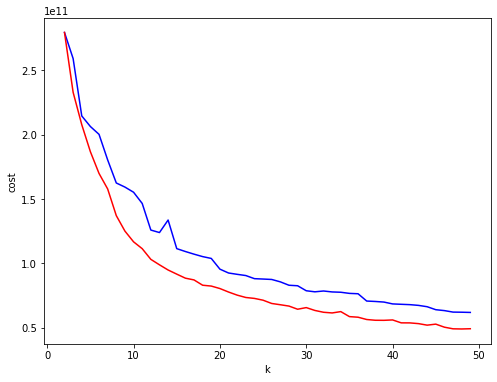

In [44]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax],color='blue')
ax.plot(range(2,kmax),kmcost[2:kmax],color='red')
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [45]:
def compare(bkmcost,kmcost):
    diff = []
    for k in range(2,kmax,5):
        temp = k,(kmcost[k]-bkmcost[k])
        diff.append(temp)
    return(diff)

diff_list = compare(bkmcost,kmcost)
diff_list 

[(2, 0.0),
 (7, -22555878713.046906),
 (12, -22744960110.519684),
 (17, -20005715387.269623),
 (22, -16150220278.066101),
 (27, -17765665399.195427),
 (32, -16513831060.430779),
 (37, -14336571230.020592),
 (42, -14169183213.527756),
 (47, -12982942567.70269)]

Looks like k-means wins by a landslide at every iteration!

## Fit final model

Looks like the elbow was at around 15 so we will stick with that. 

Now let's train our final model and we can print out the centroids of the ten clusters.

In [52]:
k = 15
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)

# bkmeans = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
# model = bkmeans.fit(df_kmeans)

# Make predictions
predictions = model.transform(df_kmeans)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
print(" ")

# Shows the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.5144033026532172
 
Cluster Centers: 
[1.02392854e+03 9.02355901e-01 2.58143768e+03 1.52895712e+03
 1.05339520e+03 5.43434037e+02 7.63231075e-01 4.69401383e-01
 5.74765590e-01 8.37250869e-02 1.92987805e+00 3.38673780e+01
 4.06125277e+03 3.59747982e+03 6.20163977e+02 2.93733363e-01
 1.18658537e+01]
[7.33338138e+02 8.45209331e-01 4.02473683e+02 1.83425469e+02
 2.19280892e+02 4.00562640e+02 4.37369617e-01 1.12469112e-01
 3.38136911e-01 1.04892197e-01 2.10606061e+00 8.24114383e+00
 2.00802117e+03 7.11273783e+02 4.40074379e+02 1.37986575e-01
 1.13301323e+01]
[3.82648500e+03 9.79798000e-01 7.47111111e+02 1.94904074e+02
 5.52207037e+02 1.04106248e+03 4.43602630e-01 5.97642222e-02
 4.02637481e-01 9.73624444e-02 3.18518519e+00 1.68148148e+01
 4.21296296e+03 1.21107605e+03 2.25177918e+04 0.00000000e+00
 1.18888889e+01]
[5.62656430e+03 9.49545450e-01 2.91751320e+04 2.36507215e+04
 5.52441050e+03 1.11562704e+03 8.90833300e-01 8.27500050e-01
 6.64999950

In [53]:
# Those are a little bit hard to read
# Let's convert to a dataframe so we can add the column names
import pandas as pd
import numpy as np
center_pdf = pd.DataFrame(list(map(np.ravel,centers)))
center_pdf.columns = columns
center_pdf

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,1023.928542,0.902356,2581.437683,1528.957119,1053.395198,543.434037,0.763231,0.469401,0.574766,0.083725,1.929878,33.867378,4061.252772,3597.479818,620.163977,0.293733,11.865854
1,733.338138,0.845209,402.473683,183.425469,219.280892,400.562640,0.437370,0.112469,0.338137,0.104892,2.106061,8.241144,2008.021174,711.273783,440.074379,0.137987,11.330132
2,3826.484997,0.979798,747.111111,194.904074,552.207037,1041.062477,0.443603,0.059764,0.402637,0.097362,3.185185,16.814815,4212.962963,1211.076049,22517.791764,0.000000,11.888889
3,5626.564299,0.949545,29175.132000,23650.721500,5524.410500,1115.627041,0.890833,0.827500,0.665000,0.045833,2.050000,123.750000,16125.000000,29449.596683,3663.840175,0.521780,11.900000
4,749.572109,0.853324,848.813734,465.880100,383.605404,186.946349,0.576080,0.271187,0.395777,0.045500,0.865281,14.612779,6518.513468,1039.432847,314.700271,0.222010,11.820631
5,6856.206488,0.984333,10489.343830,5355.510426,5133.833404,989.505567,0.919149,0.682818,0.849484,0.118440,3.148936,106.340426,15597.872340,9692.892242,3164.217744,0.199480,11.808511
6,5461.846980,0.989430,2134.645545,1322.792949,811.852596,956.459986,0.655589,0.413061,0.501795,0.170752,3.788462,32.842949,10137.820513,2678.156438,1830.418139,0.005399,11.862179
7,5702.192501,0.965300,1159.583929,621.954464,537.629464,15262.944807,0.330705,0.162125,0.274872,0.620323,28.232143,16.535714,10509.821429,15027.487721,2346.720411,0.108381,11.696429
8,3516.784521,0.959599,393.033378,223.679156,169.392800,3122.677429,0.288493,0.123232,0.192253,0.361135,9.551111,7.495556,5573.166667,2120.526741,1264.943513,0.022208,11.428889
9,2011.177886,0.982342,7369.172528,5572.115225,1797.057303,439.265458,0.910776,0.771093,0.649855,0.054818,1.398876,80.101124,7599.157303,6615.958125,961.366710,0.372242,11.949438


Awesome information! We can see the centroids for each variable at each cluster. Now we can use this data to target our customer base.

### Check the individual predictions

Let's also check out the the predictions for each row that was produced above. The prediction value is an integer between 0 and k.

In [40]:
predictions.limit(5).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,features,prediction
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,"[40.900749, 0.818182, 95.4, 0.0, 95.4, 0.0, 0....",8
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,"(3202.467416, 0.909091, 0.0, 0.0, 0.0, 6442.94...",14
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,"[2495.148862, 1.0, 773.17, 773.17, 0.0, 0.0, 1...",0
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,"[1666.670542, 0.636364, 1499.0, 1499.0, 0.0, 2...",0
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,"[817.714335, 1.0, 16.0, 16.0, 0.0, 0.0, 0.0833...",8


## Conclusions

That was awesome! Now we can use this data to target our marketing efforts! We could use these groups to target similar customer segments. For example if we do some research about the groups and discover that one is mostly a certian soicio economic status and purchasing frequency, and offer them a cost savings package that could be benficial to them. How cool would that be?!

We could also learn a bit more about our clustering by calling on various aggregate statistics for each one of the clusters across each of the variables in our dataframe like this.

In [59]:
from pyspark.sql.types import *

def median(values_list):
    med = np.median(values_list)
    return float(med)
udf_median = udf(median, FloatType())

predictions.groupBy("prediction").agg(udf_median(collect_list(predictions['BALANCE'])).alias("median")).show()

+----------+---------+
|prediction|   median|
+----------+---------+
|        12|1659.1909|
|         1|497.72684|
|        13|7025.7573|
|         6|5199.2134|
|         3|3422.8982|
|         5|6894.2197|
|         9| 1346.205|
|         4|239.52403|
|         8|3441.8362|
|         7| 5289.027|
|        10|268.72998|
|        11|2860.3823|
|        14|6022.2246|
|         2| 3034.686|
|         0| 623.1673|
+----------+---------+



In [60]:
predictions.groupBy("prediction").agg(mean("BALANCE")).show()

+----------+------------------+
|prediction|      avg(BALANCE)|
+----------+------------------+
|        12|2437.4478520117646|
|         1| 732.9255851404495|
|        13| 7212.476074514846|
|         6|5463.5861961246055|
|         3|      5626.5642989|
|         5| 6890.553774479169|
|         9| 2049.921174038461|
|         4| 743.1242703325623|
|         8| 3497.385422691966|
|         7| 5702.192501267856|
|        10| 736.5347818639057|
|        11| 3807.488434499999|
|        14|6674.0807805714285|
|         2|3826.4849973333335|
|         0|1022.4221924051996|
+----------+------------------+



In [41]:
predictions.groupBy("prediction").agg(min(predictions.BALANCE).alias("Min BALANCE"),max(predictions.BALANCE).alias("Max BALANCE")).show(15)

+----------+-----------+-----------+
|prediction|Min BALANCE|Max BALANCE|
+----------+-----------+-----------+
|        12|    0.48805|7533.854422|
|         1|   4.382924|12373.33348|
|        13|        0.0|4037.305658|
|         6|3457.086184|10571.41107|
|         3|1268.809031|13479.28821|
|         5| 782.392041|19043.13856|
|         9|        0.0|4338.558856|
|         4| 268.577278|14581.45914|
|         8|        0.0|2156.616367|
|         7| 915.717703|8097.334733|
|        10|3649.559565|18495.55855|
|        11| 166.295463|7803.071972|
|        14|        0.0|6443.077147|
|         2| 204.329381| 8161.84873|
|         0|        0.0|4071.792166|
+----------+-----------+-----------+



# LDA

In [77]:
from pyspark.sql.types import *

# from pyspark import SparkContext
# from pyspark.sql import SQLContext
# from pyspark.mllib.util import MLUtils

from pyspark.ml.feature import *
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import *

# For pipeline development in case you need it (but we won't use it here)
from pyspark.ml import Pipeline 

In [65]:
path = 'Datasets/'
df = spark.read.json(path+'recipes.json')

In [66]:
df.limit(5).toPandas()

,Author,Description,Ingredients,Method,Name,url
0,Mary Cadogan,Combine a few key Christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...
1,Mary Cadogan,An easy-to-make alternative to traditional Chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...
2,Sara Buenfeld,These beautiful and classy little cakes make l...,"[200g dark muscovado sugar, 175g butter, chopp...","[Tip the sugar, butter, dried fruit, whole che...",Christmas cupcakes,https://www.bbcgoodfood.com/recipes/72622/chri...
3,Paul Hollywood,Paul Hollywood's fruit rolls can be made ahead...,"[500g strong white flour, plus extra for dusti...",[Put the flour and 1 tsp salt into a large bow...,Christmas buns,https://www.bbcgoodfood.com/recipes/1803633/ch...
4,Barney Desmazery,"Made these for the second time today, and I ha...","[280g self-raising flour, 175g golden caster s...",[Heat oven to 190C/170 fan/gas 5 and line a 12...,Christmas cupcakes,https://www.bbcgoodfood.com/recipes/981634/chr...


In [67]:
df.printSchema()

root
 |-- Author: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Ingredients: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Method: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Name: string (nullable = true)
 |-- url: string (nullable = true)



In [68]:
from pyspark.sql.functions import *

def null_values_cal(df):
    null_values_summary = []
    numRows = df.count()
    for col in df.columns:
        num_na = df.where(df[col].isNull()).count()
        if num_na > 0:
            temp = col, num_na, num_na/numRows * 100
            null_values_summary.append(temp)
    return null_values_summary

null_values_summary = null_values_cal(df)
spark.createDataFrame(null_values_summary, ['column', 'num_na', 'pct_na']).show()

+-----------+------+------------------+
|     column|num_na|            pct_na|
+-----------+------+------------------+
|     Author|     6|0.3710575139146568|
|Description|   188|11.626468769325912|
+-----------+------+------------------+



In [69]:
df = df.na.drop(subset = ['Description'])
df.count()

1429

In [76]:
from pyspark.ml.feature import *

regex_tokenizer = RegexTokenizer(inputCol = "Description", outputCol = 'words')
raw_words = regex_tokenizer.transform(df)

stopword_filter = StopWordsRemover(inputCol = 'words', outputCol = 'filtered_words')
filtered_words = stopword_filter.transform(raw_words)

cv = CountVectorizer(inputCol = 'filtered_words', outputCol = 'features')
cvmodel = cv.fit(filtered_words)
vectorized_data = cvmodel.transform(filtered_words)

vectorized_data.select("filtered_words", "features").show(5, False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_words                                                                                                                                                   |features                                                                                                                                                          |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[combine, key, chr

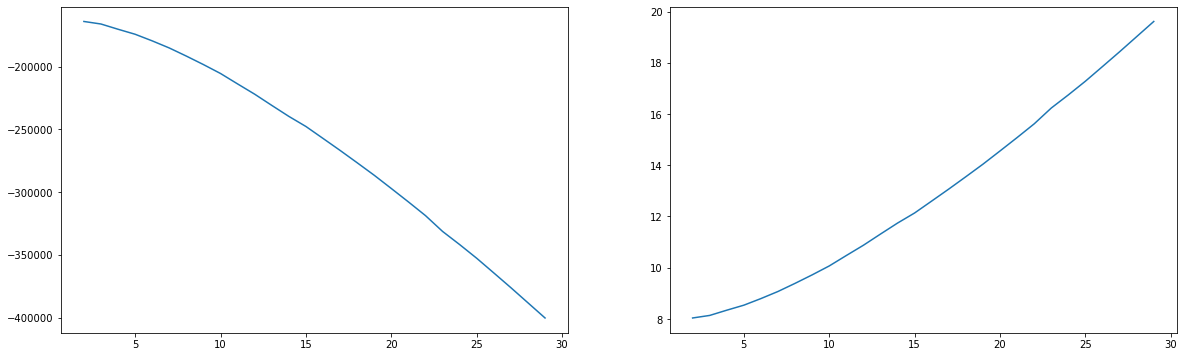

In [78]:
kmax = 30
ll = np.empty(kmax)
lp = np.empty(kmax)

for k in range(2, kmax):
    lda = LDA(k = k, maxIter = 20)
    model = lda.fit(vectorized_data)
    ll[k] = model.logLikelihood(vectorized_data)
    lp[k] = model.logPerplexity(vectorized_data)

fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ax[0].plot(range(2, kmax), ll[2:])
ax[1].plot(range(2, kmax), lp[2:])
plt.show()

In [80]:
final_lda = LDA(k = 4, maxIter = 20)
model = final_lda.fit(vectorized_data)

topics = model.describeTopics(maxTermsPerTopic=5).collect()

In [90]:
vocabulary = cvmodel.vocabulary
for x, topic in enumerate(topics):
    print("topic: "+ str(x))
    word_indexes = topic[1]
    words = [vocabulary[i] for i in word_indexes]
    print(words)

topic: 0
['creamy', 'serve', 'starter', 'seafood', 'really']
topic: 1
['-', 'creamy', 'festive', 'oven', 'simple']
topic: 2
['christmas', '-', 'make', 'perfect', 'great']
topic: 3
['made', 'bit', 'recipe', 'cream', 'christmas']


In [107]:
predictions = model.transform(vectorized_data)

#predictions = model.transform(vectorized_data)

to_array = udf(lambda x: x.toArray().tolist(), ArrayType(FloatType()))
predictions = predictions.withColumn("dist_array", to_array(predictions["topicDistribution"]))

#print(predictions.printSchema())
predictions = predictions.withColumn("max", array_max("dist_array"))

argmaxUdf = udf(lambda x, y: [i for i, j in enumerate(x) if j == y])
predictions = predictions.withColumn("topic", argmaxUdf(predictions['dist_array'], predictions['max']))

import pandas as pd
pd.set_option("display.max_colwidth", 20)
predictions.limit(5).toPandas()

,Author,Description,Ingredients,Method,Name,url,words,filtered_words,features,topicDistribution,dist_array,max,topic
0,Mary Cadogan,Combine a few ke...,[2 tbsp olive oi...,[Heat oven to 19...,Christmas pie,https://www.bbcg...,"[combine, a, few...","[combine, key, c...","(0.0, 1.0, 1.0, ...",[0.0174965837390...,[0.0174965839833...,0.943570,[2]
1,Mary Cadogan,An easy-to-make ...,"[175g butter, ch...","[Put the butter,...",Simmer-&-stir Ch...,https://www.bbcg...,"[an, easy-to-mak...","[easy-to-make, a...","(0.0, 1.0, 0.0, ...",[0.0217784110567...,[0.0217784103006...,0.930035,[2]
2,Sara Buenfeld,These beautiful ...,[200g dark musco...,"[Tip the sugar, ...",Christmas cupcakes,https://www.bbcg...,"[these, beautifu...","[beautiful, clas...","(0.0, 0.0, 1.0, ...",[0.0157260070855...,[0.0157260075211...,0.949461,[2]
3,Paul Hollywood,Paul Hollywood's...,[500g strong whi...,[Put the flour a...,Christmas buns,https://www.bbcg...,"[paul, hollywood...","[paul, hollywood...","(0.0, 0.0, 0.0, ...",[0.0133881361519...,[0.0133881364017...,0.956635,[2]
4,Barney Desmazery,Made these for t...,[280g self-raisi...,[Heat oven to 19...,Christmas cupcakes,https://www.bbcg...,"[made, these, fo...","[made, second, t...","(0.0, 1.0, 1.0, ...",[0.0078394325869...,[0.0078394329175...,0.496575,[3]


# GMM

In [115]:
path ="Datasets/"
df = spark.read.csv(path+'sales_data_sample.csv',inferSchema=True,header=True)
df.limit(5).toPandas()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport...,None,NYC,NY,10022,USA,NA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,None,Reims,None,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colone...,None,Paris,None,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,None,Pasadena,CA,90003,USA,NA,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,None,San Francisco,CA,None,USA,NA,Brown,Julie,Medium


In [116]:
df.printSchema()

root
 |-- ORDERNUMBER: integer (nullable = true)
 |-- QUANTITYORDERED: integer (nullable = true)
 |-- PRICEEACH: double (nullable = true)
 |-- ORDERLINENUMBER: integer (nullable = true)
 |-- SALES: double (nullable = true)
 |-- ORDERDATE: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- QTR_ID: integer (nullable = true)
 |-- MONTH_ID: integer (nullable = true)
 |-- YEAR_ID: integer (nullable = true)
 |-- PRODUCTLINE: string (nullable = true)
 |-- MSRP: integer (nullable = true)
 |-- PRODUCTCODE: string (nullable = true)
 |-- CUSTOMERNAME: string (nullable = true)
 |-- PHONE: string (nullable = true)
 |-- ADDRESSLINE1: string (nullable = true)
 |-- ADDRESSLINE2: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- POSTALCODE: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- TERRITORY: string (nullable = true)
 |-- CONTACTLASTNAME: string (nullable = true)
 |-- CONTACTFIRSTNAME: string (nullable = tr

In [117]:
import matplotlib.pyplot as plt

from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import GaussianMixture
import numpy as np

In [118]:
col = ["QUANTITYORDERED","PRICEEACH","SALES"]
num_null = []
numRows = df.count()
for k in col:
    col_na = df.where(df[k].isNull()).count()
    num_null.append((k, col_na, col_na/numRows))
    if col_na > 0:
        print("column: {}, number of nulls: {}".format(k, col_na))
        avg_val = df.agg(mean(k)).collect()[0][0]
        df.na.fill(avg, subset = [k])
        print("filled with average: {}".format(avg_val))

null_df = spark.createDataFrame(num_null, ['column', 'number of nulls', 'pct of nulls'])
null_df.show()


+---------------+---------------+------------+
|         column|number of nulls|pct of nulls|
+---------------+---------------+------------+
|QUANTITYORDERED|              0|         0.0|
|      PRICEEACH|              0|         0.0|
|          SALES|              0|         0.0|
+---------------+---------------+------------+



In [120]:
df = df.select(col)

In [121]:
input_columns = df.columns
vectorizer = VectorAssembler(inputCols = input_columns, outputCol = 'features')
vectorized_data = vectorizer.transform(df)
vectorized_data.show(5)

+---------------+---------+-------+--------------------+
|QUANTITYORDERED|PRICEEACH|  SALES|            features|
+---------------+---------+-------+--------------------+
|             30|     95.7| 2871.0|  [30.0,95.7,2871.0]|
|             34|    81.35| 2765.9| [34.0,81.35,2765.9]|
|             41|    94.74|3884.34|[41.0,94.74,3884.34]|
|             45|    83.26| 3746.7| [45.0,83.26,3746.7]|
|             49|    100.0|5205.27|[49.0,100.0,5205.27]|
+---------------+---------+-------+--------------------+
only showing top 5 rows



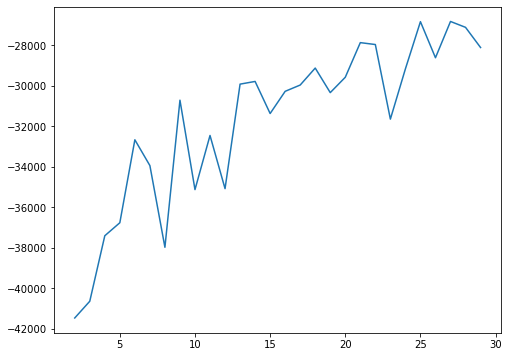

In [123]:
kmax = 30
ll = np.zeros(kmax)

for k in range(2, kmax):
    gmm = GaussianMixture(k = k, seed = 1)
    model = gmm.fit(vectorized_data)
    summary = model.summary
    ll[k] = summary.logLikelihood

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(2, kmax), ll[2:])
plt.show()

In [126]:
gmm = GaussianMixture(k = 5, maxIter = 100, seed = 1)
model = gmm.fit(vectorized_data)

summary = model.summary
print("clusters: ", summary.k)
print("cluster size: ", summary.clusterSizes)
print("Loglikelihood: ", summary.logLikelihood)

transformed = model.transform(vectorized_data)
transformed.limit(5).toPandas()

clusters:  5
cluster size:  [358, 347, 409, 1314, 395]
Loglikelihood:  -36759.64746147443


,QUANTITYORDERED,PRICEEACH,SALES,features,probability,prediction
0,30,95.70,2871.00,"[30.0, 95.7, 287...",[7.1671500829539...,1
1,34,81.35,2765.90,"[34.0, 81.35, 27...",[0.0298704102811...,1
2,41,94.74,3884.34,"[41.0, 94.74, 38...",[0.0060926754129...,1
3,45,83.26,3746.70,"[45.0, 83.26, 37...",[0.9987738624236...,0
4,49,100.00,5205.27,"[49.0, 100.0, 52...",[1.0916512957848...,3


In [127]:
transformed.printSchema()

root
 |-- QUANTITYORDERED: integer (nullable = true)
 |-- PRICEEACH: double (nullable = true)
 |-- SALES: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [128]:
to_array = udf(lambda x: x.toArray().tolist(), ArrayType(FloatType()))
predictions = transformed.withColumn('probability_array', to_array('probability'))

max_vals = predictions.withColumn("max", array_max("probability_array"))

find_index = udf(lambda x, y: [i for i,j in enumerate(x) if j == y][0], IntegerType())
predictions = max_vals.withColumn("index", find_index("probability_array", "max"))

predictions.show(5)


+---------------+---------+-------+--------------------+--------------------+----------+--------------------+----------+-----+
|QUANTITYORDERED|PRICEEACH|  SALES|            features|         probability|prediction|   probability_array|       max|index|
+---------------+---------+-------+--------------------+--------------------+----------+--------------------+----------+-----+
|             30|     95.7| 2871.0|  [30.0,95.7,2871.0]|[7.16715008295391...|         1|[7.16715E-11, 0.9...|0.99665636|    1|
|             34|    81.35| 2765.9| [34.0,81.35,2765.9]|[0.02987041028113...|         1|[0.02987041, 0.64...| 0.6455187|    1|
|             41|    94.74|3884.34|[41.0,94.74,3884.34]|[0.00609267541292...|         1|[0.0060926755, 0....| 0.9939072|    1|
|             45|    83.26| 3746.7| [45.0,83.26,3746.7]|[0.99877386242362...|         0|[0.9987739, 0.001...| 0.9987739|    0|
|             49|    100.0|5205.27|[49.0,100.0,5205.27]|[1.09165129578487...|         3|[1.0916513E-10, 1...|  

In [129]:
predictions.groupby("prediction").agg(count('prediction'), mean("QUANTITYORDERED"), mean("PRICEEACH"), mean("SALES")).show()

+----------+-----------------+--------------------+-----------------+------------------+
|prediction|count(prediction)|avg(QUANTITYORDERED)|   avg(PRICEEACH)|        avg(SALES)|
+----------+-----------------+--------------------+-----------------+------------------+
|         1|              347|   34.01152737752162| 91.8714697406341| 3125.540951008647|
|         3|             1314|   35.21080669710807| 99.9977092846271|  4846.53917047184|
|         4|              395|   26.50379746835443| 70.1018987341772|1856.7907848101272|
|         2|              409|  35.603911980440095| 46.5978973105134|1665.0719070904654|
|         0|              358|  44.600558659217874|73.02483240223458|3254.9354748603364|
+----------+-----------------+--------------------+-----------------+------------------+



In [138]:
def median(values_list):
    med = np.median(values_list)
    return float(med)
udf_median = udf(median, FloatType())

predictions.groupBy("prediction").agg(udf_median(collect_list(predictions['QUANTITYORDERED'])).alias("median")).show()

+----------+------+
|prediction|median|
+----------+------+
|         1|  33.0|
|         3|  35.0|
|         4|  26.0|
|         2|  36.0|
|         0|  45.0|
+----------+------+



In [139]:
find_median = udf(lambda x: float(np.median(x)), FloatType())
predictions.groupBy("prediction").agg(find_median(collect_list(predictions["QUANTITYORDERED"]))).show()

+----------+---------------------------------------------+
|prediction|<lambda>(collect_list(QUANTITYORDERED, 0, 0))|
+----------+---------------------------------------------+
|         1|                                         33.0|
|         3|                                         35.0|
|         4|                                         26.0|
|         2|                                         36.0|
|         0|                                         45.0|
+----------+---------------------------------------------+

